# Part 3: Recognition

In this part of the assignment, you will implement and train neural networks, including convolutional neural networks, for an image recognition task using PyTorch. Specifically, we will classify a number of grayscale images of pieces of clothing by predicting a label for the name of the clothing type.

**Learning objectives.** You will:
1. Define multilayer perceptrons and convolutional neural networks using PyTorch
2. Optimize neural networks using automatic differentation and minibatch stochastic gradient descent in PyTorch
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

While it is possible to complete this task using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

In [1]:
#!/usr/bin/env python
# Run but DO NOT MODIFY this code

# Import modules
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Load Fashion MNIST datasets
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

The following code then visualizes some random examples of the training data.

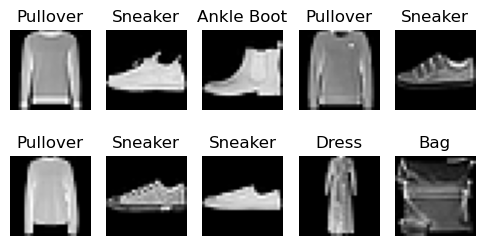

In [2]:
# Run but DO NOT MODIFY this code

# Visualize Random Examples
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

from matplotlib import pyplot as plt

figure = plt.figure(figsize=(6, 3))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


## Task 1

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a multilayer perceptron to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least at least two [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to connect between the input, hidden units, and an output units. You should use nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) at least for the hidden units. You may optionally include additional layers but are not required to do so.

Your model should not be excessively large beyond what is necessary to accomplish good performance (see the next task). After your code, briefly explain the architecture of your model including a discussion of the hidden layers and the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [9]:
# Write code for task 1 here

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

class MLP(torch.nn.Module):
    """Multilayer Perceptron for image classification in PyTorch."""
    def __init__(self, in_size=None, out_size=None, h_size=100, lr=0.01, epochs=3):
        super(MLP, self).__init__()
        self.lr = lr
        self.epochs = epochs
        self.h_size = h_size
        self.in_size = in_size
        self.out_size = out_size
        # Initialize these layers later
        self.w1 = None
        self.w2 = None

        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    def forward(self, x):
        """Forward pass."""
        x = func.relu(self.w1(x))
        x = self.w2(x)
        return x

    def fit(self, train_dl, val_dl=None):
        """Train the model using the given DataLoader."""
        self.to(self.device)

        # Compute input and output sizes from train_dl
        first_batch = next(iter(train_dl))
        inputs, labels = first_batch
        flattened_inputs = inputs.flatten(start_dim=1)
        self.in_size = flattened_inputs.shape[1]

        # Get out_size
        unique_labels = set()
        for _, labels in train_dl:
            unique_labels.update(labels.tolist())
        self.out_size = len(unique_labels)
        # Initialize layers
        self.w1 = torch.nn.Linear(self.in_size, self.h_size).to(self.device)
        self.w2 = torch.nn.Linear(self.h_size, self.out_size).to(self.device)

        loss_fn = nn.CrossEntropyLoss()
        opt = optim.SGD(self.parameters(), lr=self.lr)

        self.train()
        for epoch in range(self.epochs):
            total_loss = 0
            correct = 0
            total = 0
            for inputs, labels in train_dl:
                inputs = inputs.flatten(start_dim=1)
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                opt.zero_grad()

                # Forward propagation
                outputs = self.forward(inputs)
                loss = loss_fn(outputs, labels)

                # Backpropagation
                loss.backward()
                opt.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            train_acc = correct / total
            val_acc = self.evaluate(val_dl) if val_dl else "N/A"
            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {total_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc}")

    def predict_proba(self, inputs):
        """Compute class probabilities."""
        probs = []
        self.eval()
        with torch.no_grad():
            outputs = self.forward(inputs)
            probs.append(func.softmax(outputs, dim=1))
        return torch.cat(probs)

    def predict(self, inputs):
        all_preds = []
        probs = self.predict_proba(inputs)
        _, predicted = torch.max(probs, dim=1)
        all_preds.append(predicted.cpu())
        return torch.cat(all_preds)

    def evaluate(self, test_dl):
        """Evaluate model accuracy on a test DataLoader."""
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.to(self.device)
        self.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_dl:
                inputs = inputs.to(self.device)
                inputs = inputs.flatten(start_dim=1)
                labels = labels.clone().detach().to(self.device)
                predicted = self.predict(inputs).to(self.device)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        return correct / total

In [14]:
mlp = MLP()
mlp.fit(train_loader)
total_params = sum(p.numel() for p in mlp.parameters())
print(f"Total parameters: {total_params}")

Epoch 1/3, Training Loss: 928.9862, Training Accuracy: 0.6310, Validation Accuracy: N/A
Epoch 2/3, Training Loss: 538.1988, Training Accuracy: 0.7570, Validation Accuracy: N/A
Epoch 3/3, Training Loss: 459.0799, Training Accuracy: 0.7963, Validation Accuracy: N/A
Total parameters: 79510


*Briefly explain for task 1 here*

This model contains 2 linear layers, with 1 hidden layer. The hidden layer, by default, contains 100 hidden units. The computation for the number of parameters is shown above. There is an input size of 784 (28x28 for the number of pixels in an image) so this results in 79,510 total parameters.

## Task 2

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)).

You should be able to achieve a validation accuracy of 83% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 1 if so) or the training hyperparameters to accomplish this. 

When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data. Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [5]:
# Write code for task 2 here
mlp = MLP(h_size=120, epochs=10, lr=0.1)
mlp.fit(train_loader, val_loader)
acc = mlp.evaluate(test_loader)
print(f"Test Accuracy: {acc:.4f}")
total_params = sum(p.numel() for p in mlp.parameters())
print(f"Total number of parameters: {total_params}")


Epoch 1/10, Training Loss: 497.2999, Training Accuracy: 0.7711, Validation Accuracy: 0.8213333333333334
Epoch 2/10, Training Loss: 341.7706, Training Accuracy: 0.8367, Validation Accuracy: 0.82775
Epoch 3/10, Training Loss: 306.1529, Training Accuracy: 0.8527, Validation Accuracy: 0.8470833333333333
Epoch 4/10, Training Loss: 286.4280, Training Accuracy: 0.8631, Validation Accuracy: 0.8423333333333334
Epoch 5/10, Training Loss: 270.5846, Training Accuracy: 0.8689, Validation Accuracy: 0.85175
Epoch 6/10, Training Loss: 257.7441, Training Accuracy: 0.8762, Validation Accuracy: 0.8721666666666666
Epoch 7/10, Training Loss: 248.4721, Training Accuracy: 0.8801, Validation Accuracy: 0.8743333333333333
Epoch 8/10, Training Loss: 240.0101, Training Accuracy: 0.8835, Validation Accuracy: 0.8758333333333334
Epoch 9/10, Training Loss: 233.0125, Training Accuracy: 0.8852, Validation Accuracy: 0.8714166666666666
Epoch 10/10, Training Loss: 225.0328, Training Accuracy: 0.8905, Validation Accuracy: 

*Briefly explain for task 2 here*

The final accuracy of the model on test data was 86.86%. I chose an h_size of 120, meaning that there are 120 nodes in the hidden layer. This allowed my model to use 95,410 parameters, which is just under the maximum allowed number of 100,000. Testing showed that this high model complexity did not lead to overfitting. I chose the number of epochs to be 10, as this was sufficient for the model accuracy to rise above the required threshold of 83%. I chose a relatively high learning rate of 0.1. In my initial experimentation, I had a learning rate of 0.01 (the default). This showed a constant increase in accuracy even after 40 epochs, but the model's rate of improvement was extremely slow. So, I increased the learning rate to 0.1 and decreased the number of epochs to 10, and achieved even better results than before in significantly less time. With a learning rate of 0.1 and 40 epochs, the test accuracy was 88.26%, but the execution time was about 1 minute and 40 seconds, which may be too slow. So, I ultimately went with lr=0.1 and epochs=10.

## Task 3

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a convolutional neural network to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least one [convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), at least one [pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), and at least one fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), though you may choose to use a deeper model with additional layers to achieve good performance.

Your model should not be excessively large beyond what is necessary to accomplish good performance. After your code, briefly explain the architecture of your model including a discussion of all of the hidden layers including choice of any parameters such as kernels or strides, as well as the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [6]:
# Write code for task 3 here
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

class ConvNN(torch.nn.Module):
    """Definition of a convolutional neural network for classification 
    in Pytorch, inheriting from the torch.nn.Module base class."""
    def __init__(self, epochs=10, hidden_layer_size=100, c1_out=32, c2_out=64, lr=0.01):
        super().__init__()
        self.epochs = epochs
        self.lr = lr
        self.conv_stack = nn.Sequential(
                                nn.Conv2d(in_channels=1, out_channels=c1_out,
                                    kernel_size=(5,5), stride=1, padding='same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                                nn.Conv2d(in_channels=c1_out, out_channels=c2_out,
                                    kernel_size=(3,3), stride=1, padding='same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2,2), stride=2)
                            )
        self.flatten = nn.Flatten()
        self.linear_layers = nn.Sequential(
                                            nn.Linear(in_features=7*7*c2_out,
                                                     out_features=hidden_layer_size),
                                            nn.ReLU(),
                                            nn.Linear(in_features=hidden_layer_size,
                                                      out_features=10),
                                            nn.Softmax(dim=1)
                                        )
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    def forward(self, x):
        """ Compute logits for batch x by forward propagation.
        Parameters
        ----------
        x : tensor, shape = [n_examples, n_channels, width, height]
        """
        x = self.conv_stack(x)
        x = self.flatten(x)
        return self.linear_layers(x)

    def fit(self, train_dl, val_dl=None):
        """Train the model using the given DataLoader."""
        self.to(self.device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)

        for epoch in range(self.epochs):
            total_loss = 0
            correct = 0
            total = 0
            for batch, (inputs, labels) in enumerate(train_dl):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)


                # Forward propagation
                outputs = self.forward(inputs)

                # Loss computation
                loss = loss_fn(outputs, labels)

                writer.add_scalar("Training Loss", loss, epoch)

                # Backward propagation
                loss.backward()

                # Gradient step
                optimizer.step()
                optimizer.zero_grad()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                if (val_dl):
                    with torch.no_grad():
                        val_in, val_labels = next(iter(val_dl))
                        val_in = val_in.to(self.device)
                        val_labels = val_labels.to(self.device)
                        # Forward propagation
                        val_out = self.forward(val_in)
                        # Loss computation
                        val_loss = loss_fn(val_out, val_labels)
                        writer.add_scalar("Validation Loss", val_loss, epoch)

            train_acc = correct / total
            val_acc = self.evaluate(val_dl) if val_dl else 0
            writer.add_scalar("Validation Accuracy", val_acc, epoch)
            # print(f"Epoch {epoch+1} of {self.epochs}, Validation Accuracy: {val_acc:.4f}")

    def predict_proba(self, inputs):
        """Compute class probabilities."""
        probs = []
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():
            outputs = self.forward(inputs)
            probs.append(func.softmax(outputs, dim=1))
        return torch.cat(probs)

    def predict(self, inputs):
        all_preds = []
        probs = self.predict_proba(inputs)
        _, predicted = torch.max(probs, dim=1)
        all_preds.append(predicted.cpu())  # Move to CPU for easier handling
        return torch.cat(all_preds)  # Concatenate predictions from all mini-batches

    def evaluate(self, test_dl):
        """Evaluate model accuracy on a test DataLoader."""
        self.to(self.device)
        self.eval()  # Set model to evaluation mode
        loss_fn = nn.CrossEntropyLoss()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_dl:
                inputs = inputs.to(self.device)
                labels = labels.clone().detach().to(self.device)
                predicted = self.predict(inputs).to(self.device)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        return correct / total
        


In [ ]:
cnn = ConvNN(lr=0.2, epochs=40, c1_out=16, c2_out=32, hidden_layer_size=60)
cnn.fit(train_loader, val_dl=val_loader)
total_params = sum(p.numel() for p in cnn.parameters())
print(f"Total parameters: {total_params}")
writer.flush()
writer.close()


KeyboardInterrupt: 

*Briefly explain for task 3 here*
This model contains convolutional layers followed by pooling layers, in the convolutional stack. Then, the end has fully connected linear layers. The total # of parameters is shown above.

## Task 4

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). 

Instead of using printouts to monitor training, use the more professional PyTorch `Tensorboard` utility as [described in the tutorial documentation here](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html). Log the (a) training loss, (b) validation loss, and (c) validation accuracy over the course of training using `Tensorboard` (you likely only want to compute validation accuracy once per epoch, but you can log the loss more often if you wish). For your final training run, report the visualizations created by Tensorboard. You can export the visualizations from Tensorboard by selecting "SCALARs" (upper left), "Show data download links", and "Download" under each image, or you can just take screenshots. You can [add images using markdown as shown in the documentation](https://www.markdownguide.org/cheat-sheet/#basic-syntax).

You should be able to achieve a validation accuracy of 88% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 3 if so) or the training hyperparameters to accomplish this. In particular, you should demonstrate improved performance (while still using fewer than 100,000 parameters) compared to your previous multilayer perceptron. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [ ]:
# Write code for task 4 here
# Wrote code for Tensorboard in the task 3 code
total_params = sum(p.numel() for p in cnn.parameters())
print(f"Total number of parameters: {total_params}")
test_acc = cnn.evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


Total number of parameters: 99806
Test Accuracy: 0.8943


![alt text](./Training_Loss.png)

![alt text](./Validation_Loss.png)

![alt text](./Validation_Accuracy.png)

*Briefly explain for task 4 here*

For the training of my final model, I chose the following hyperparameters: lr=0.2, epochs=40, c1_out=16, c2_out=32, and hidden_layer_size=60. Firstly, I chose those values for c1_out and c2_out, and hidden_layer_size because they made the total parameter count 99,806, which is just below the maximum allowed parameters of 100,000. I chose c2_out to be greater than c1_out because deeper layers typically have more output channels since they capture more complex features of the data. I tried various values for hidden_layer_size before finding that anything more than 60 did not significantly improve accuracy. I chose 40 for the number of epochs because validation accuracy seemed to increase all the way until the final epoch, which indicates that the model is not overfit. Finally, I chose a relatively high learning rate of 0.2 because anything more seemed to increase the potential for volatility in training, leading to inconsistent test accuracy, and anything less caused unnecessarily slow training.